# Imports

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import plot_confusion_matrix
import plotly.express as px
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [2]:
type_log = pd.read_csv('../data/type_log.csv')

# Problem Statement

I want to build a multiclass classification model (Decision Tree, SVM, KNN) that will input a geologic type log and be able to pick the desired geologic formation tops and return the values to the user.  And possibly warn the user if there is any section missing which we call a fault.

### What is Gamma Ray?

Different types of rock emit different amounts and different spectra of natural gamma radiation.  In particular, shales usually emit more gamma rays than other sedimentary rocks, such as sandstone, gypsum, salt, coal, dolomite, or limestone this is because radioactive potassium is a common component in their clay content, and because the cation exchange capacity of clay causes them to absorb uranium and thorium.

### How do Gamma Ray tools work?

The tool that measures gamma radiation is a common piece of the bottom hole assembly along with a motor and drilling bit.  As the rig drills through the rock, the gamma ray tool collects data from the rocks, which helps geologists identify their position.  The rig drills rock a couple of different ways.  The first is by using a mechanical drill bit with diamond teeth that turns and cuts through the rock, much like you use a hand drill to cut through wood.  The second way is like a power washer, there are holes in the drilling bit that shoot mud forward that actually does the majority of the drilling.  The drilling mud is one of the most important parts of the whole operation.  Like I said, it helps actually drill the hole, it also has numerous properties that are constantly checked.  These properties keep the mud a certain weight and viscosity which holds dangerous gas in the hole.  If the mud doesn't have the correct properties, the gas can literally flow out of the hole and explode or burn a drilling rig down within minutes.  The third reason for drilling mud is it carries the rocks that we are drilling to the surface and cleans the hole.  The geologist on site examines these rocks to also judge position along with oil content etc.  The fourth and most important reason for the mud these days is it helps the people who run the gamma ray tool to send signals to the surface.  There is a small piston in the tool that displaces the mud, sending morse code like signals to a computer on the surface that collects these signals and translates them for our normal work computers to interpret.  The second geologist looks at these graphs and compares them with other gamma ray data in the area to judge their position in the stratigraphic column.  The geologist on site and the one examining the gamma ray logs stay in constant communication, making sure they are drilling where they are supposed to for the most efficient and productive wells possible.

# EDA

Below is an example of what EDA I would normally do, to clean up the data so I can use it for my project.  Since the files originally come from the well site in a format called LAS and I already knew how to reformat them in Microsoft Excel.  I decided to just clean the data quickly in Excel while changing the format simultanously.

In [3]:
# type_log.head(10_000)

,DEPT,NPHI,GR,TENS,GRTH,LLS,LLD,MSFL,CALI,CAL1,RHOB,DRHO,PE,DPHI,MDT,SPHI,ITTI,ITTT,XPHI
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.3733,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500
2,0.8733,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500
3,1.3733,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500
4,1.8733,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500,-999.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4997.3733,0.0700,66.5357,4219.8101,15.5603,79.3923,87.5616,44.6094,9.2109,8.8883,2.6068,0.0112,2.7031,0.0641,61.3558,0.1001,30.6779,390749.3438,0.0719
9996,4997.8733,0.0617,62.5368,4301.5542,17.4984,72.8831,75.5762,54.9272,9.1378,8.8931,2.5988,0.0068,2.6839,0.0691,61.2389,0.0993,61.2389,390718.6563,0.0682
9997,4998.3733,0.0710,70.0908,4191.8403,23.4621,57.9067,61.4559,35.6144,9.1386,8.9059,2.5736,0.0017,2.6172,0.0847,61.8355,0.1036,30.9177,390657.4063,0.0800
9998,4998.8733,0.0846,82.3271,4147.4614,29.9231,47.9719,55.0196,22.5361,9.1776,8.9010,2.5374,-0.0018,2.5662,0.1072,61.8355,0.1036,30.9177,390657.4063,0.0974


In [4]:
# type_log.shape

(21050, 19)

In [5]:
# type_log.dtypes

DEPT    float64
NPHI    float64
GR      float64
TENS    float64
GRTH    float64
LLS     float64
LLD     float64
MSFL    float64
CALI    float64
CAL1    float64
RHOB    float64
DRHO    float64
PE      float64
DPHI    float64
MDT     float64
SPHI    float64
ITTI    float64
ITTT    float64
XPHI    float64
dtype: object

In [6]:
# type_log = type_log.dropna(how = 'all')

In [7]:
# type_log.drop(type_log[type_log['GR'] < 0].index, inplace = True)

In [8]:
# type_log.head()

,DEPT,NPHI,GR,TENS,GRTH,LLS,LLD,MSFL,CALI,CAL1,RHOB,DRHO,PE,DPHI,MDT,SPHI,ITTI,ITTT,XPHI
200,99.8733,0.4530,40.1618,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
201,100.3733,0.5271,42.1417,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
202,100.8733,0.4311,38.1820,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
203,101.3733,0.4813,35.9287,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25
204,101.8733,0.5825,36.8431,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25,-999.25


In [9]:
# type_log.drop(columns=['NPHI', 'TENS', 'GRTH', 'LLS', 'LLD', 'MSFL', 'CALI', 'CAL1', 'RHOB', 'DRHO', 'PE', 'DPHI', 'MDT', 'SPHI', 'ITTI', 'ITTT', 'XPHI'], inplace=True)

In [10]:
# type_log.head()

,DEPT,GR
200,99.8733,40.1618
201,100.3733,42.1417
202,100.8733,38.1820
203,101.3733,35.9287
204,101.8733,36.8431


In [11]:
# type_log.shape

(20575, 2)

# Modeling

In [9]:
type_log = pd.read_csv('../data/Log_1_TC.csv')

In [10]:
type_log.head()

,DEPT,DPHI,GR,ILD,FORMATION
0,4899.5,5.025,108.452,9.543,1
1,4900.0,4.945,104.012,10.139,1
2,4900.5,4.549,97.739,11.076,1
3,4901.0,4.311,93.312,11.531,1
4,4901.5,4.153,91.193,11.970,1


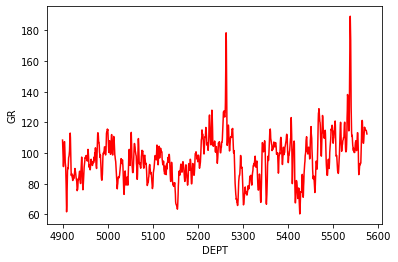

In [11]:
sns.lineplot(data=type_log, x="DEPT", y="GR", color='red');

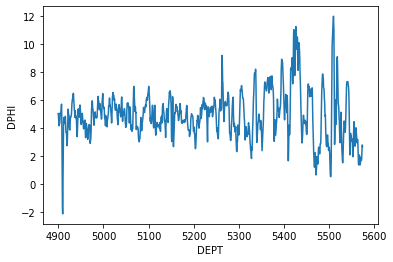

In [14]:
sns.lineplot(data=type_log, x="DEPT", y="DPHI");

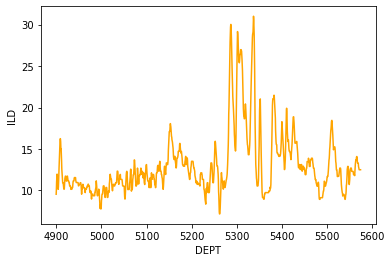

In [16]:
sns.lineplot(data=type_log, x="DEPT", y='ILD', color='orange');

In [17]:
type_log = type_log.dropna()

In [18]:
type_log.isnull().sum()

DEPT         0
DPHI         0
GR           0
ILD          0
FORMATION    0
dtype: int64

In [20]:
X = type_log.drop(columns='FORMATION', axis=1)
y = type_log.FORMATION
ss = StandardScaler().fit(X)
X_sc = ss.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_sc,y)

In [22]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [23]:
knn.score(X_train,y_train)

0.9891518737672583

In [24]:
knn.score(X_test, y_test)

0.9644970414201184

In [25]:
preds = knn.predict(X_test)

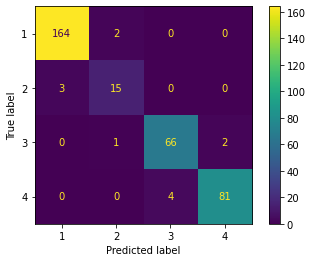

In [33]:
plot_confusion_matrix(knn, X_test, y_test);

In [29]:
rfc = RandomForestClassifier(min_samples_leaf=3)
rfc.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=3)

In [30]:
rfc.score(X_train,y_train)

1.0

In [32]:
rfc.score(X_test, y_test)

0.9970414201183432

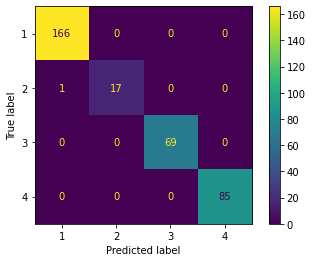

In [34]:
plot_confusion_matrix(rfc, X_test, y_test);